# Table of contents
1. [Introduction](#assignment2)
2. [Assignment 2](#assignment2)  
    2.1 [Data set](#assign2dataset)  
    2.2 [Data Analysis](#assign2dataanalysis)  
    2.3 [Vectorizer](#assign2vectorizer)  
    2.4 [Data Visualization](#assign2datavis)  
    2.5 [Classifier](#assign2classifier)  
    2.6 [Resampling](#assign2resampling)  
    2.7 [Result Discussion](#assign2result)  
3. [Another paragraph](#paragraph2)

## This is the introduction <a name="introduction"></a>
Some introduction text, formatted in heading 2 style

##  2.0 Assignment 2  <a name='assignment2'></a>  

The goal of this assignment is to create a model that can perform sentiment analysis. To achieve this we'll be training it on the provided dataset, containing sentiments classfied as positive, neutral, or negative.

**Required Imports/Downloads**

In [1]:
%pip install spacy imblearn nltk numpy pandas wordcloud
!python -m spacy download nb_core_news_sm

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 12.5/12.5 MB 3.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('nb_core_news_sm')


In [2]:
import numpy as np
import spacy
import re
import nltk
import pickle
import json
import pandas as pd
from spacy.lang.nb import Norwegian
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import BorderlineSMOTE
from wordcloud import WordCloud
from matplotlib import colors
import matplotlib.pyplot as plt

# from nltk.corpus import wordnet as wn

In [3]:
# nltk.download("stopwords")
# nltk.download("wordnet")

### 2.1 Data set <a name='assign2dataset'><a/>

The data set is provided as a set of three JSON files containing separate training, testing, and validation sets. We begin by loading all three files into a `data` variable.

As the text in the data set is Norwegian, we begin by loading the set of Norwegian stop words and the spaCy natural language processing pipeline for Norwegian Bokmål.

In [4]:
data = {}
stops = stopwords.words('norwegian')
nlp = spacy.load('nb_core_news_sm')

In [5]:
for name in ["train", "dev", "test"]:
    with open("{0}.json".format(name)) as infile:
        data[name] = json.load(infile)

Next we load the train and test data into dataframes, and separate input text from labels.

In [32]:
train = pd.DataFrame.from_dict(data["train"])
test = pd.DataFrame.from_dict(data["test"])
# train
# test

In [31]:
X_train_raw = train['text']
y_train = train['label']

X_test_raw = test['text']
y_test = test['label']

# X_train_raw

### 2.2 Data analysis <a name='assign2dataanalysis'><a/>

We begin by analyzing the training and test datasets. As shown by `value_counts`, the majority of samples in both datasets are classified as neutral. The training dataset contains a total of approx. 8000 samples, while test contains 1200.

Additionally we can display 10 random samples to understand the format of the input.

In [8]:
train.value_counts('label')

label
Neutral     4079
Positive    2624
Negative    1270
dtype: int64

In [30]:
test.value_counts('label')

label
Neutral     598
Positive    401
Negative    182
dtype: int64

In [9]:
train.sample(n=10)

,sent_id,text,label
7556,107375-03-01,"En hjertevarm , munter-vemodig film om alderdo...",Positive
7606,200520-20-02,De startes og kjøres uten særlige forsinkelser...,Positive
7859,103942-02-01,( Def Jam South / Universal ),Neutral
6461,600007-12-01,"Hvorfor Will Smith ble castet som Lucifer , er...",Negative
2272,200099-11-01,Ikke knappeløs,Neutral
2373,111260-09-04,3 Utvikler :,Neutral
5036,202043-08-03,Du vet umiddelbart hvor alt befinner seg .,Positive
864,111141-02-02,Man sitter i kinoens mørke og tenker :,Neutral
213,111035-11-04,Ubisoft,Neutral
111,701363-12-02,Nå er den bare litt mer enn bra nok .,Negative


### 2.2 Data processing <a name='assign2dataprocess'><a/>  
  
Since we cannot go straight from raw text to fitting a model to the data we need to clean up the text first. Splitting the text into words, handling punctuation and lower casing everything. The function in the next cell cleans up the data, taking into account norwegian characters, removing special characters, removes all single characters, removes inconsistent spacing, and lemmatizes the text. The if-statements are for debug and data visualization purposes.     

Step by step of what the function does:
**Original: "Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm"**  
  
`re.sub(r'\s+[a-zA-ZæøåÆØÅ]\s+', ' ', document)` Removes single characters, and `re.sub(r'\^[a-zA-ZæøåÆØÅ]\s+', ' ', document)` removes single characters at the start of a sentiment.  

**Removed single characters: "Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm"**  

`re.sub(r'\s+', ' ', document, flags=re.I)` is used to remove inconsistent spacing, replacing it with a single space instead. `document.lower()` is just a built in python function to make text lowercase.

**Lowercase: "med integrerte høyttalere som på ingen måte er diskret plassert og med en stor subwoofer inkludert da snakker vi om en gutteskjerm"**  

Finally the text is lemmatized using `document = nlp(document)`.

**Lemmatized**: `['med', 'integrert', 'høyttal', 'som', 'på', 'ingen', 'måte', 'være', 'diskre', 'plassere', 'og', 'med', 'en', 'stor', 'subwoof', 'inkludere', 'da', 'snakke', 'vi', 'om', 'en', 'gutteskjerm']`

In [10]:
stemmer = nlp.get_pipe('lemmatizer')

def clean_text(X: list[str], n_to_print=0):
    documents = []
    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))

        #if len(documents) < n_to_print:
        #    print('Original:', document)

        # remove all single characters
        document = re.sub(r'\s+[a-zA-ZæøåÆØÅ]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-ZæøåÆØÅ]\s+', ' ', document)

        #if len(documents) < n_to_print:
        #    print('Removed single characters:', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Converting to Lowercase
        document = document.lower()

        #if len(documents) < n_to_print:
        #    print('Lowercase:', document)

        # Lemmatization
        document = nlp(document)

        document = [word.lemma_ for word in document]

        #if len(documents) < n_to_print:
        #    print('Lemmatized:', document)
        document = ' '.join(document)

        documents.append(document)
    return documents

### 2.3 Vectorizer <a name='assign2vectorizer'><a/> 
  
The Vectorizer we've chosen for this task is the TfidVectorizer. Tfid stands for "Term Frequence-inverse Document Frequency". The vectorizer converts data to a matrix of said TD-IDF features. It's equivelant to doing a `CountVectorizer` followed by `TfidfTransformer`. The vectorizer is where we grab the stopwords for use in the model.  
  
The point of using tf-idf instead of raw-frequencies is to reduce the impact very frequent words and increase the impact of words that occur less frequently. For example, this is different to how a Bag of Words implementation functions as it just creates vectors with the count of each occurance of a word.

In [11]:
# Vectorizer defined here, as well as stopwords being implemented into the the vectorizer.
vectorizer = TfidfVectorizer(stop_words=stops, ngram_range=(1,2))

In [34]:
X_train_lemmas = clean_text(X_train_raw, 2)
X_test_lemmas = clean_text(X_test_raw)

X_train = vectorizer.fit_transform(X_train_lemmas).toarray()
X_test = vectorizer.transform(X_test_lemmas).toarray()

### 2.4 Data visualization <a name='assign2datavis'></a>
Now that the data has been vectorized, we can see below that it produces a large array of mostly 0, as expected. To visualize some of the words and their frequency in the data-set post processing we can use a wordcloud to illustrate the most frequently used words. 

In [33]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

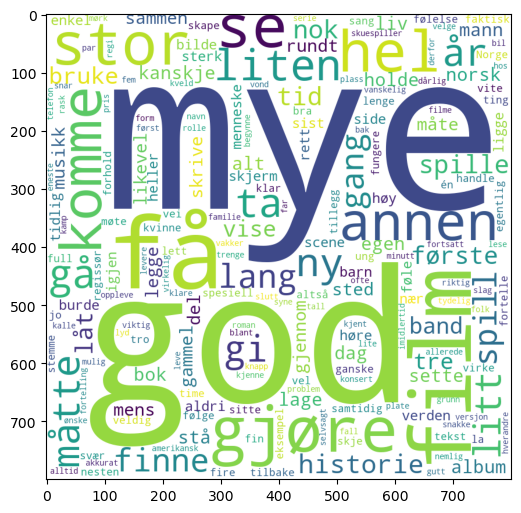

In [13]:
X_train_wc = []

for i in X_train_lemmas:
    for k in i.split():
        if k not in stops:
            X_train_wc.append(k)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                # stopwords = stopwords,
                min_font_size = 10).generate((' '.join(X_train_wc)))

# print(X_train_wc)
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.tight_layout(pad = 0)

plt.show()

Unfortunately this approach does not take into account the TFIDvectorized data or labels from the data set, and just bases it of of word frequency. Because of this, there is not much useful to see, but nonetheless there is some information we can get from it. "God" can conventionally be associated with a positive sentiment, but most of the other words in this wordcloud can be neutral, positive, or negative. 

### 2.5 Classifier  <a name='assign2classifier'></a>
  
For the classifier we've tried `SGDClassifier`, `MultinomialNB`, and `BernoulliNB`.  

In [15]:
classifierB = BernoulliNB()
classifierB.fit(X_train, y_train)
y_predB = classifierB.predict(X_test)
print(f'BernoulliNB: {accuracy_score(y_test, y_predB)}')

BernoulliNB: 0.5097375105842507


In [16]:
classifierM = MultinomialNB()
classifierM.fit(X_train, y_train)
y_predM = classifierM.predict(X_test)
print(f'MultinomialNB: {accuracy_score(y_test, y_predM)}')

MultinomialNB: 0.56731583403895


In [17]:
classifier = SGDClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [18]:
print(f'Non-rescaled: {accuracy_score(y_test, y_pred)}')

Non-rescaled: 0.6291278577476714


In [19]:
print(confusion_matrix(y_test, y_pred))

[[ 38  82  62]
 [ 27 455 116]
 [ 28 123 250]]


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.41      0.21      0.28       182
     Neutral       0.69      0.76      0.72       598
    Positive       0.58      0.62      0.60       401

    accuracy                           0.63      1181
   macro avg       0.56      0.53      0.53      1181
weighted avg       0.61      0.63      0.61      1181



As you can see by the results both `MultinomialNB`, and `BernoulliNB` produced quite poor results so we went with `SGDClassifier` as it produced the best overall result of the three. However the result are bad, but expected given the provided data set we have to use for the assignment. 

### 2.6 Resampling  <a name='assign2resampling'></a>

For this data-set .63 accuracy is to be expected, but still quite bad. In an attempt to remedy this we tried resampling the data-set using `BorderlineSMOTE`. This algorithm generates additional samples similar to those present in the data set, providing additional samples to under-represented classes. In this data set it creates significantly more negative and positive data-points for the classifier to work with. This can however reduce accuracy as it essentially fills the data set with filler data, which can make it more difficult for the model to be trained.

In [21]:
resampler = BorderlineSMOTE(random_state=123)

X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)

Let's see how many values it has once resampled.

In [22]:
y_train_res.value_counts() # Rescaled

Neutral     4079
Negative    4079
Positive    4079
Name: label, dtype: int64

In [23]:
y_train.value_counts() # non-Rescaled

Neutral     4079
Positive    2624
Negative    1270
Name: label, dtype: int64

As you can see the difference in number of values quite significant. This makes for a very skewed data-set which is quite suboptimal for machine learning. A skewed data-set can lead to the model not identifying the correct sentiment making the training inneficcient.  

So let's feed it back into the classifier and see what accuracy it achives when the input-data is equalized. We don't expect it to do much, as it's still roughly the same data, but it can interesting to look at the difference in the classification report.

In [24]:
classifier_res = SGDClassifier()
classifier_res.fit(X_train_res, y_train_res)
y_pred_res = classifier_res.predict(X_test)

In [25]:
print(f'Rescaled: {accuracy_score(y_test, y_pred_res)}')

Rescaled: 0.6121930567315834


In [26]:
print(confusion_matrix(y_test, y_pred_res))

[[ 50  71  61]
 [ 61 415 122]
 [ 38 105 258]]


In [27]:
print(classification_report(y_test, y_pred_res))

              precision    recall  f1-score   support

    Negative       0.34      0.27      0.30       182
     Neutral       0.70      0.69      0.70       598
    Positive       0.59      0.64      0.61       401

    accuracy                           0.61      1181
   macro avg       0.54      0.54      0.54      1181
weighted avg       0.61      0.61      0.61      1181



### 2.7 Results Discussion  <a name='assign2result'></a>

The results of this sentiment analysis are not great, 0.63 accuracy is practically a coinflip and is not practically useful, but is expected from the given data-set. In an attempt to improve the accuracy we rescaled the data-set to try and account for the skewed data-set, but still seeing quite bad results. The reason for this could be a poor choice of machine learning, but we think the main issue is that the skewed data-set doesn't give the model enough to go off of.

Analysing the classification reports we can glean some information about the model. In the first classification report the model has a negative recall of `.19`, meaning that out of `100` negative sentences, it would misclassify `81` of them. These numbers are slightly improved in the rescaled classifier, to `.29` negative recall. The numbers of neutral and positive recall are significantly higher, but similarly are also quite poor. For negative precision we see it scores `.45` meaning that for `55` of the sentences if the classifier says it's negative, it's wrong. In the rescaled classifier the negative precision actually goes down significantly to `.33`, meaning that for `67` of the sentences the classifier says is negative is wrong.

The main reason for this poor, but expected result is the severely skewed data-set as shown earlier. There are ~4000 neutral and ~2700 positive sentiments compared to only ~1200 negative sentiments. This leads to the model not being able to classify negative sentiments properly. Which is onviously not desirable when doing sentiment analysis. We think the approach to sentiment analysis outlined in this assignment would work on a better data set.